In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms

class VAE(nn.Module):
    def __init__(self, patch_size=4):
        super(VAE, self).__init__()
        self.patch_size = patch_size
        self.patch_dim = patch_size * patch_size  # 16 for 4x4 patches
        
        # Encoder layers
        self.encoder_layer1 = nn.Linear(self.patch_dim, 4)  # 16 -> 4
        self.encoder_mu = nn.Linear(4, 2)  # 4 -> 2
        self.encoder_logvar = nn.Linear(4, 2)  # 4 -> 2

        # Decoder layers
        self.decoder_layer1 = nn.Linear(2, 4)  # 2 -> 4
        self.decoder_layer2 = nn.Linear(4, self.patch_dim)  # 4 -> 16

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -0.5, 0.5)
                nn.init.uniform_(m.bias, -0.5, 0.5)

    def encode(self, x):
        h1 = F.softplus(self.encoder_layer1(x))
        mu = self.encoder_mu(h1)
        logvar = self.encoder_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z):
        h3 = F.softplus(self.decoder_layer1(z))
        return torch.sigmoid(self.decoder_layer2(h3))

    def forward(self, x):
        # Input shape: [B, C, H, W] = [batch_size, 1, 128, 128]
        B, C, H, W = x.shape
        # Number of patches in height and width
        n_h = H // self.patch_size  # 128/4 = 32
        n_w = W // self.patch_size  # 128/4 = 32
        
        # Reshape input into patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, C, -1, self.patch_dim)
        patches = patches.permute(0, 2, 1, 3).contiguous().view(-1, self.patch_dim)

        # Process through VAE
        mu, logvar = self.encode(patches)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)

        # Reshape back to image
        reconstructed = reconstructed.view(B, n_h, n_w, self.patch_size, self.patch_size)
        reconstructed = reconstructed.permute(0, 1, 3, 2, 4).contiguous()
        reconstructed = reconstructed.view(B, 1, H, W)

        return reconstructed, mu, logvar

Epoch 10/100, Average Loss: 925.4045


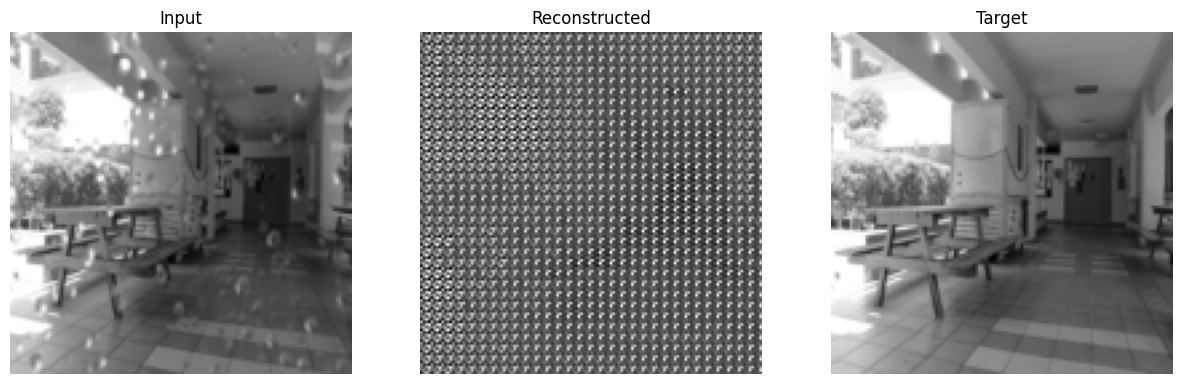

Epoch 20/100, Average Loss: 478.4322


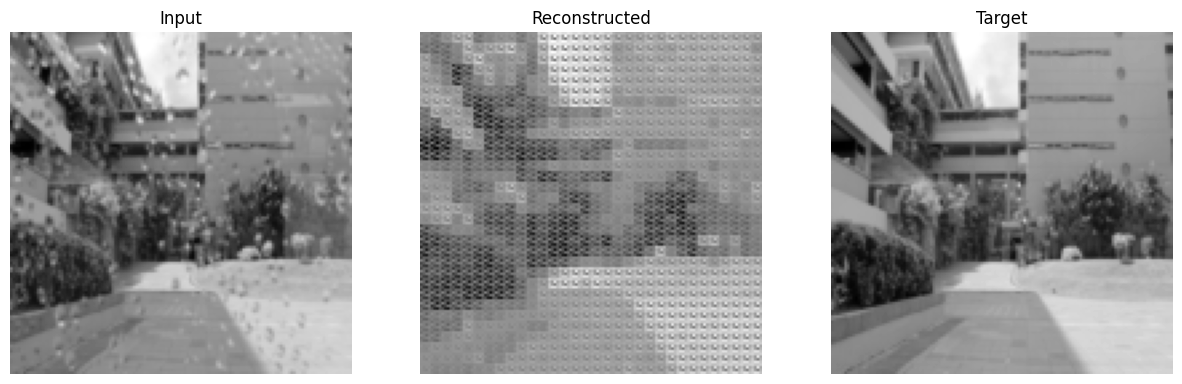

Epoch 30/100, Average Loss: 214.1295


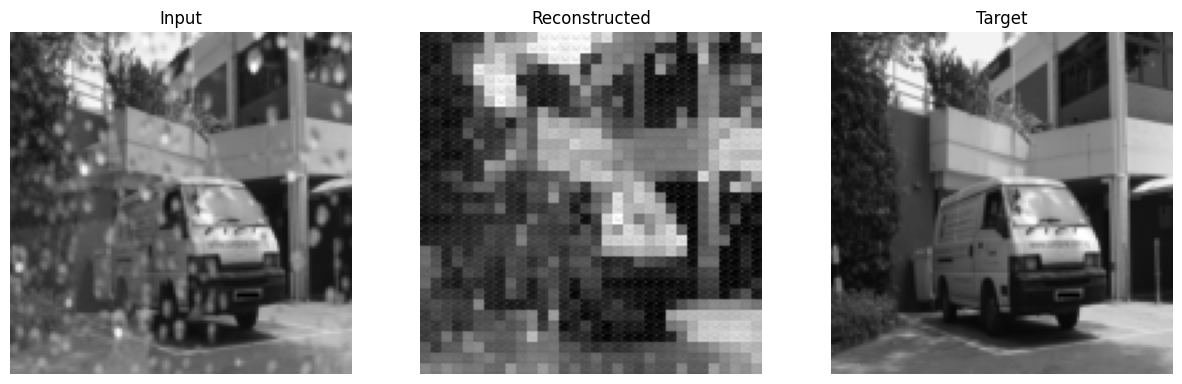

Epoch 40/100, Average Loss: 206.4853


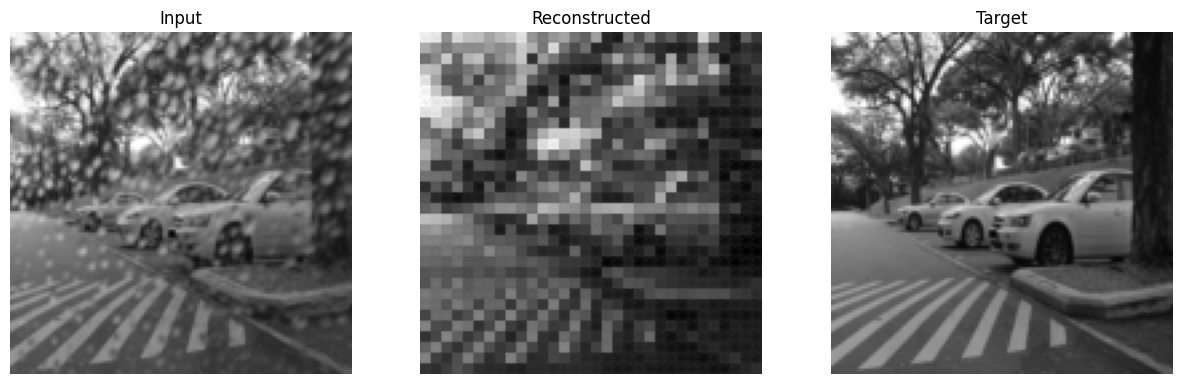

Epoch 50/100, Average Loss: 205.1206


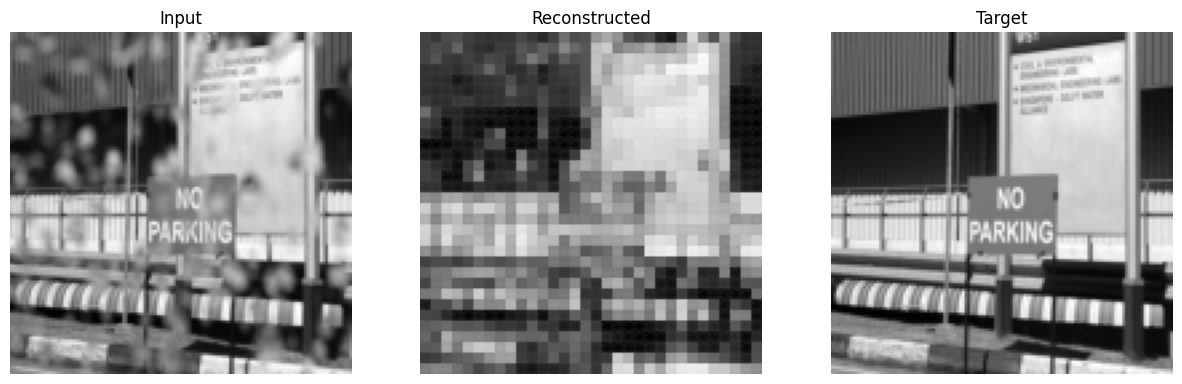

Epoch 60/100, Average Loss: 203.6397


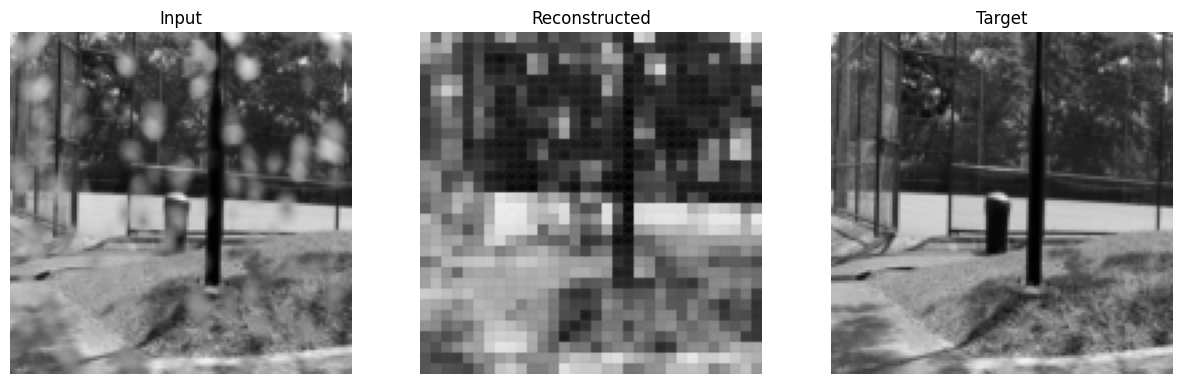

Epoch 70/100, Average Loss: 203.1245


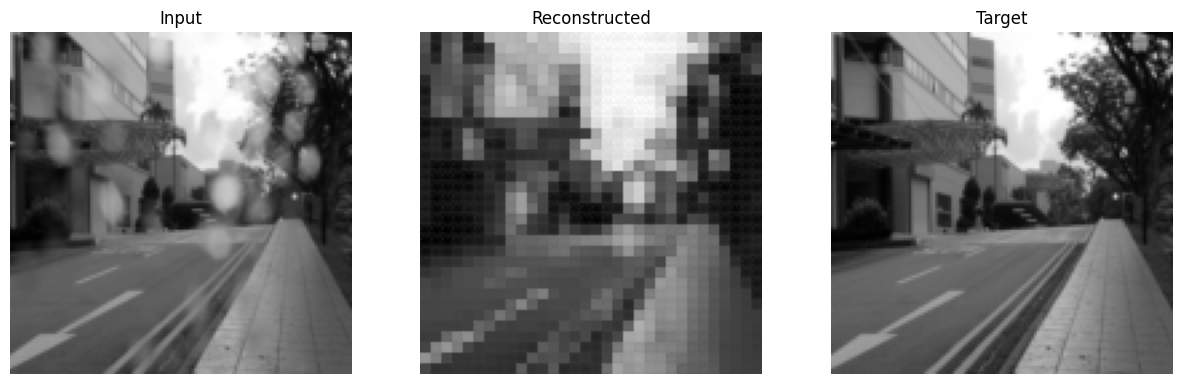

Epoch 80/100, Average Loss: 202.1256


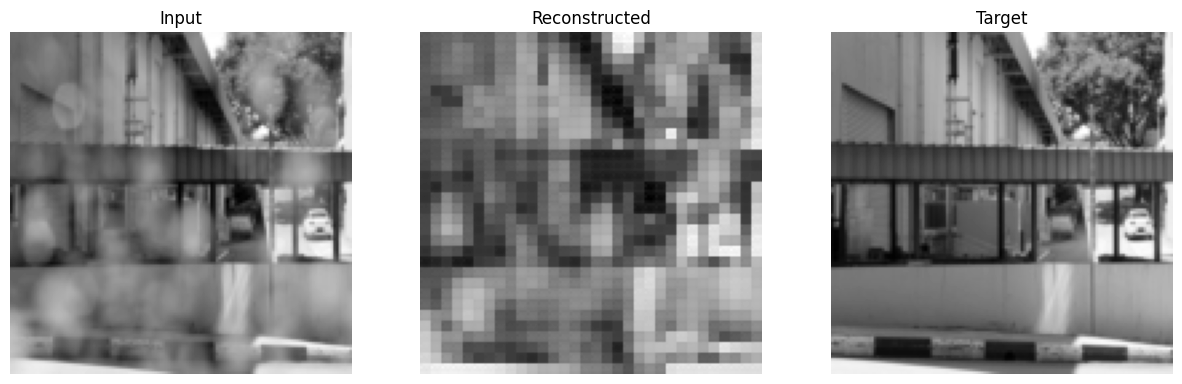

Epoch 90/100, Average Loss: 201.5431


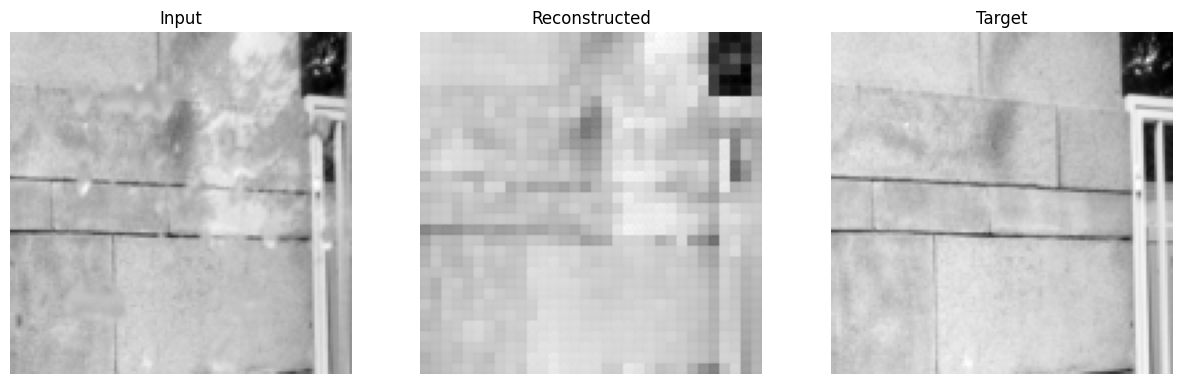

Epoch 100/100, Average Loss: 201.0419


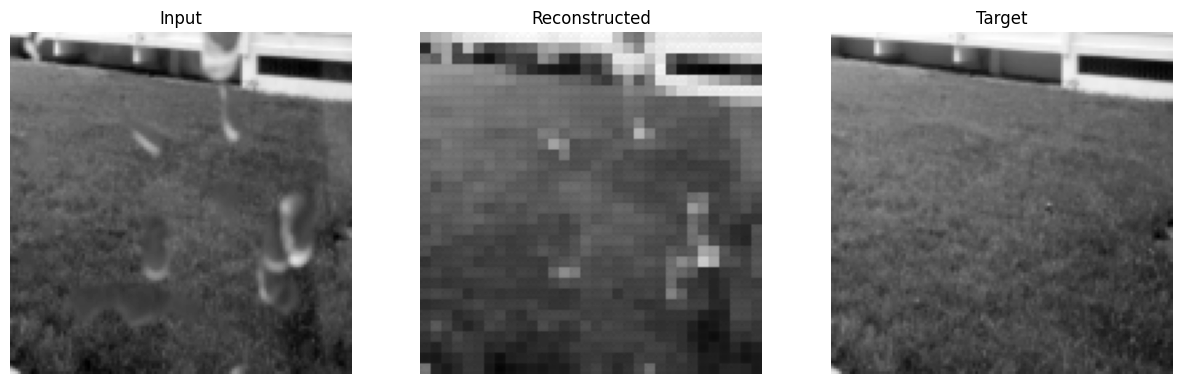

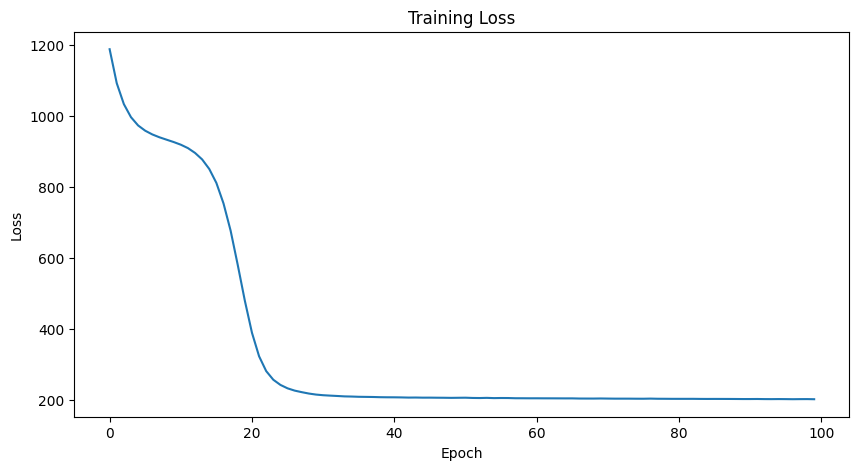

Exporting weights to Verilog...


In [2]:
class RaindropDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()  # Values in [0,1]
        ])
        self.raindrop_dir = os.path.join(root_dir, 'data')
        self.clean_dir = os.path.join(root_dir, 'gt')
        
        self.raindrop_files = sorted([f for f in os.listdir(self.raindrop_dir) if f.endswith('.png')])
        self.clean_files = sorted([f for f in os.listdir(self.clean_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.raindrop_files)
    
    def __getitem__(self, idx):
        raindrop_path = os.path.join(self.raindrop_dir, self.raindrop_files[idx])
        clean_path = os.path.join(self.clean_dir, self.clean_files[idx])
        
        raindrop_image = Image.open(raindrop_path).convert('L')
        clean_image = Image.open(clean_path).convert('L')
        
        raindrop_image = self.transform(raindrop_image)
        clean_image = self.transform(clean_image)
        
        return raindrop_image, clean_image

def train_vae(model, train_loader, num_epochs=2000, learning_rate=1e-3, beta=0.001, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (raindrop, clean) in enumerate(train_loader):
            raindrop = raindrop.to(device)
            clean = clean.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(raindrop)
            
            # Reconstruction loss
            recon_loss = F.mse_loss(recon_batch, clean, reduction='sum')
            
            # KL divergence loss - calculated for all patches
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Total loss
            loss = recon_loss + beta * kl_loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
            
            # Validate with a test batch
            model.eval()
            with torch.no_grad():
                raindrop, clean = next(iter(train_loader))
                raindrop = raindrop.to(device)
                recon_batch, _, _ = model(raindrop)
                visualize_reconstruction(raindrop[0], recon_batch[0], clean[0])
                
    return train_losses

def visualize_reconstruction(input_img, recon_img, clean_img):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(input_img[0].cpu().numpy(), cmap='gray')
    ax1.set_title('Input')
    ax1.axis('off')

    ax2.imshow(recon_img[0].cpu().numpy(), cmap='gray')
    ax2.set_title('Reconstructed')
    ax2.axis('off')
    
    ax3.imshow(clean_img[0].cpu().numpy(), cmap='gray')
    ax3.set_title('Target')
    ax3.axis('off')

    plt.show()

def to_fixed_point(number, frac_bits=10):
    scaled = number * (2 ** frac_bits)
    return int(np.round(scaled))

def export_weights_verilog(model, filename):
    with open(filename, 'w') as f:
        # First encoder layer weights (16->4)
        for i in range(16):  # input dimension (4x4 patch)
            for j in range(4):  # output dimension
                weight = model.encoder_layer1.weight[j][i].item()
                fixed_weight = to_fixed_point(weight)
                sign = "" if weight >= 0 else "-"
                f.write(f"wire signed [WEIGHT_WIDTH-1:0] w1_{i+1}{j+1} = {sign}16'd{abs(fixed_weight)}; " +
                       f"// {weight:.4f} * 1024\n")
        f.write("\n")

        # Encoder mu weights (4->2)
        for i in range(4):
            for j in range(2):
                weight = model.encoder_mu.weight[j][i].item()
                fixed_weight = to_fixed_point(weight)
                sign = "" if weight >= 0 else "-"
                f.write(f"wire signed [WEIGHT_WIDTH-1:0] w_mu_{i+1}{j+1} = {sign}16'd{abs(fixed_weight)}; " +
                       f"// {weight:.4f} * 1024\n")
        f.write("\n")

        # Encoder logvar weights (4->2)
        for i in range(4):
            for j in range(2):
                weight = model.encoder_logvar.weight[j][i].item()
                fixed_weight = to_fixed_point(weight)
                sign = "" if weight >= 0 else "-"
                f.write(f"wire signed [WEIGHT_WIDTH-1:0] w_sigma_{i+1}{j+1} = {sign}16'd{abs(fixed_weight)}; " +
                       f"// {weight:.4f} * 1024\n")
        f.write("\n")

        # First decoder layer weights (2->4)
        for i in range(2):
            for j in range(4):
                weight = model.decoder_layer1.weight[j][i].item()
                fixed_weight = to_fixed_point(weight)
                sign = "" if weight >= 0 else "-"
                f.write(f"wire signed [WEIGHT_WIDTH-1:0] w3_{i+1}{j+1} = {sign}16'd{abs(fixed_weight)}; " +
                       f"// {weight:.4f} * 1024\n")
        f.write("\n")

        # Second decoder layer weights (4->16)
        for i in range(4):
            for j in range(16):
                weight = model.decoder_layer2.weight[j][i].item()
                fixed_weight = to_fixed_point(weight)
                sign = "" if weight >= 0 else "-"
                f.write(f"wire signed [WEIGHT_WIDTH-1:0] w4_{i+1}{j+1} = {sign}16'd{abs(fixed_weight)}; " +
                       f"// {weight:.4f} * 1024\n")
        f.write("\n")

        # Export all biases
        # Encoder layer 1 bias (4)
        for i in range(4):
            bias = model.encoder_layer1.bias[i].item()
            fixed_bias = to_fixed_point(bias)
            sign = "" if bias >= 0 else "-"
            f.write(f"wire signed [BIAS_WIDTH-1:0] b1_{i+1} = {sign}16'd{abs(fixed_bias)}; " +
                   f"// {bias:.4f} * 1024\n")
        f.write("\n")

        # Encoder mu/logvar biases (2 each)
        for i in range(2):
            bias = model.encoder_mu.bias[i].item()
            fixed_bias = to_fixed_point(bias)
            sign = "" if bias >= 0 else "-"
            f.write(f"wire signed [BIAS_WIDTH-1:0] b_mu_{i+1} = {sign}16'd{abs(fixed_bias)}; " +
                   f"// {bias:.4f} * 1024\n")

        for i in range(2):
            bias = model.encoder_logvar.bias[i].item()
            fixed_bias = to_fixed_point(bias)
            sign = "" if bias >= 0 else "-"
            f.write(f"wire signed [BIAS_WIDTH-1:0] b_sigma_{i+1} = {sign}16'd{abs(fixed_bias)}; " +
                   f"// {bias:.4f} * 1024\n")
        f.write("\n")

        # Decoder layer 1 bias (4)
        for i in range(4):
            bias = model.decoder_layer1.bias[i].item()
            fixed_bias = to_fixed_point(bias)
            sign = "" if bias >= 0 else "-"
            f.write(f"wire signed [BIAS_WIDTH-1:0] b3_{i+1} = {sign}16'd{abs(fixed_bias)}; " +
                   f"// {bias:.4f} * 1024\n")

        # Decoder layer 2 bias (16)
        for i in range(16):
            bias = model.decoder_layer2.bias[i].item()
            fixed_bias = to_fixed_point(bias)
            sign = "" if bias >= 0 else "-"
            f.write(f"wire signed [BIAS_WIDTH-1:0] b4_{i+1} = {sign}16'd{abs(fixed_bias)}; " +
                   f"// {bias:.4f} * 1024\n")

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dataset and dataloader
    dataset = RaindropDataset("/home/irman/Documents/Pytorch-Course/4_VAE/data/train")
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Create and train model
    model = VAE().to(device)
    losses = train_vae(model, train_loader, num_epochs=100, device=device)
    
    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    print("Exporting weights to Verilog...")
    export_weights_verilog(model, 'vae_weights_v1.v')

In [3]:
# save the model
torch.save(model.state_dict(), 'vae_v1.pth')

### Test Model

In [4]:
# load the model
model = VAE()
model.load_state_dict(torch.load('vae_v1.pth'))
model.eval()

# prepare a sample image
raindrop = Image.open('/home/irman/Documents/Pytorch-Course/4_VAE/data/train/data/90_rain.png').convert('L')
raindrop = transforms.Resize((128, 128))(raindrop)
raindrop = transforms.ToTensor()(raindrop).unsqueeze(0)

In [5]:
raindrop.shape

torch.Size([1, 1, 128, 128])

In [6]:
128*128

16384

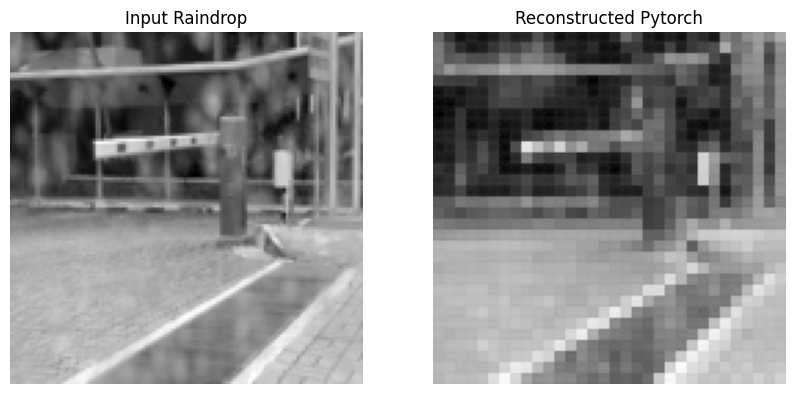

In [7]:
# run the model
recon, _, _ = model(raindrop)

# visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raindrop[0][0].cpu().numpy(), cmap='gray')
plt.title('Input Raindrop')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(recon[0][0].detach().cpu().numpy(), cmap='gray')
plt.title('Reconstructed Pytorch')
plt.axis('off')
plt.show()

In [44]:
import torch
import numpy as np

# Assume `raindrop` is a PyTorch tensor with shape (1, 1, 128, 128)
scaled_input = (raindrop * 1024).round().clip(-32768, 32767)  # Scale and clip
scaled_input = scaled_input.detach().cpu().numpy().astype(np.int16)  # Convert to NumPy and cast to int16

# Reshape to 2D (if saving as an image-like structure) or flatten to 1D
scaled_input_reshaped = scaled_input.reshape(-1)  # Flatten the 4D tensor

# Save as hex
np.savetxt("raindrop_hex3.txt", scaled_input_reshaped, fmt='%04x')  # Save as hex


### Check Results from Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms

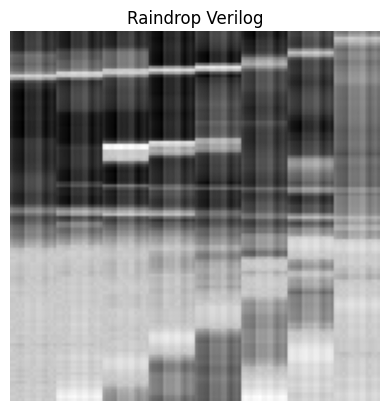

In [2]:
# plot raindrop from txt
raindrop = np.loadtxt('results4.txt')
raindrop = torch.tensor(raindrop).view(1, 1, 128, 128)

plt.imshow(raindrop[0][0].cpu().numpy(), cmap='gray')
plt.title('Raindrop Verilog')
plt.axis('off')
plt.show()